In [1]:
from plotting import imshow
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# RGB training data load
yuv_train_set = unpickle('yuv_train')

# Image names 
filenames = [f.decode('utf-8') for f in yuv_train_set[b'filenames']]

# Getting the images
yuv_images_data = yuv_train_set[b'data'].copy() 

In [4]:
# Input tensor(H,W,C) -> output tensor(C,H,W)
def yuv_rgb(array):
    new_array = array.numpy().astype(np.float32).copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    
    return torch.tensor((new_array*255).astype(np.uint32)).permute(2, 0, 1)

In [5]:
class YUVImageClassificationDataset(Dataset):
    def __init__(self, filenames, images_data, bin_count=50):
        self.filenames = filenames # image name
        self.images_data = images_data # images data: data used to construct the images 
        self.bin_count = bin_count # number of bins used 
        self.bins = np.linspace(0, 1, bin_count)  # Bin edges
        # we are creating bins between 0 and 1 in order to have the values of u and v

    def __len__(self):
        return len(self.filenames)
    
    def bin_labels(self, values):
        return np.digitize(values, self.bins) -1 # Map values to bin indices
                                                   # This function takes values and assigns each value to a bin index
                                                   # based on self.bins. It returns the index starting from 0

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint32)

        Y_channel = (img[0:1024].reshape(32, 32, 1) / 255).astype(np.float32)
        U_channel = (img[1024:2048].reshape(32, 32, 1) / 255).astype(np.float32)
        V_channel = (img[2048:].reshape(32, 32, 1) / 255).astype(np.float32)
        #return y, u, v, self.filenames[idx]

    
        #return Y_channel, U_channel, V_channel, self.filenames[idx]

        # Binned shapes are (H,W)
        U_binned = self.bin_labels(U_channel)  # Discretize U 
        V_binned = self.bin_labels(V_channel)  # Discretize V


        return Y_channel, U_binned, V_binned, self.filenames[idx]



### Creating a lookup table

In [6]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50,dtype=torch.float32).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [7]:
# Loading the RGB images
yuv_dataset = YUVImageClassificationDataset(filenames=filenames, images_data=yuv_images_data)
yuv_train_loader = DataLoader(yuv_dataset, batch_size=8, shuffle = False)

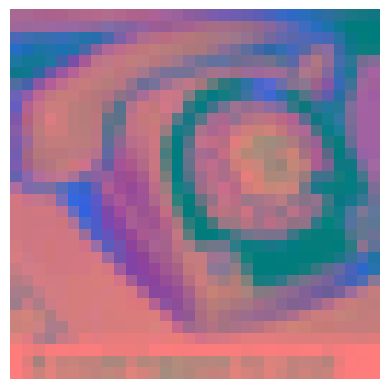

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4294967295].


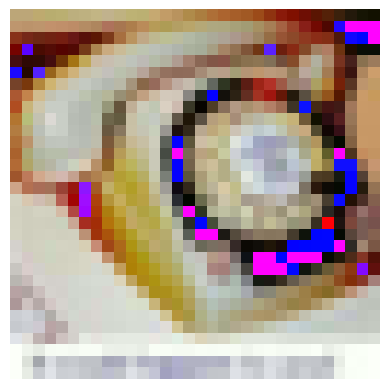

In [ ]:
for Y_channel, U_binned, V_binned, fname in yuv_train_loader:
    
    # shape (8,32,32,1) 
    U_target_rec = unbin_labels(U_binned.clone().detach())
    V_target_rec = unbin_labels(V_binned.clone().detach())
    
    #shape (8,3,32,32)
    img_batch = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)
    
    imggg = img_batch[5]
    imshow(imggg)
    rgb_output = yuv_rgb(imggg.permute(1,2,0))

    imshow(rgb_output) 
    
    
    break

In [13]:
# ----- CLASSIFICATION CNN MODEL -----
class PretrainedClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(PretrainedClassificationCNN, self).__init__()
        
        # Use a pretrained MobileNetV2 as an encoder
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.encoder = mobilenet.features[:-1]  # Remove last downsampling to preserve spatial info
        
        # Adaptive pooling to maintain spatial size (Adjusted to match 32x32 output)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))  # Adjusted output size
        
        # Initial Convolutional Layers (Adjust input channels to match MobileNetV2 output)
        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Replace max pooling with upsampling
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Skip Connections
        self.skip0 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv_final = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        
        # Output Layers for Classification (Updated output channels to 50)
        self.output_U = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.output_V = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)  # Convert grayscale (1-channel) to 3-channel
        x = self.encoder(x)
        x = self.adaptive_pool(x)  # Maintain resolution
        x = self.conv1(x)
        x = self.upsample1(x)  # Upsample instead of pooling
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.skip0(x)
        x = self.conv_final(x)
        u = self.output_U(x)
        v = self.output_V(x)
        return u, v



In [14]:

bin_count = 50
model = PretrainedClassificationCNN(bin_count).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
total_loss = []
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, U_target, V_target, fname in yuv_train_loader:
        Y_channel, U_target, V_target = Y_channel.permute(0,3,1,2).to(device), U_target.permute(0,3,1,2).to(device), V_target.permute(0,3,1,2).to(device)

        optimizer.zero_grad()
        U_pred, V_pred = model(Y_channel)
        #print('U pred: \n',U_pred)

        loss_U = criterion(U_pred, U_target.squeeze(1))
        loss_V = criterion(V_pred, V_target.squeeze(1))
        loss = loss_U + loss_V

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(yuv_train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), f"models/pretrainedclassification_{num_epochs}ep.pth")

Epoch [1/10], Loss: 5.0217
Epoch [2/10], Loss: 5.0058
Epoch [3/10], Loss: 5.0032
Epoch [4/10], Loss: 5.0020
Epoch [5/10], Loss: 5.0014
Epoch [6/10], Loss: 5.0013
Epoch [7/10], Loss: 5.0007
Epoch [8/10], Loss: 5.0003
Epoch [9/10], Loss: 5.0003
Epoch [10/10], Loss: 5.0000


In [16]:
def converter(pred):
    softmax = nn.Softmax(dim = 1).to(device)
    probs = softmax(pred)
    _, ind = torch.topk(probs,1,1)
    return ind

In [17]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [19]:
model.load_state_dict(torch.load("models/pretrainedclassification_10ep.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [29..257].


Filename: bos_taurus_s_000507.png


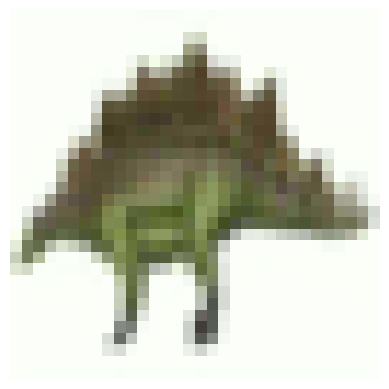

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [51..257].


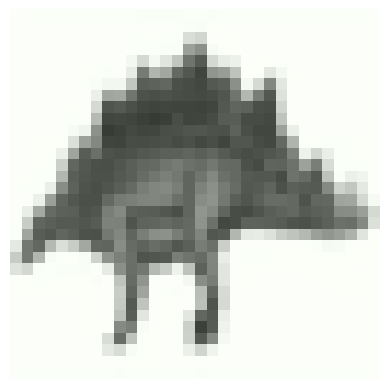

In [21]:
for Y_channel, U_target, V_target, fname in yuv_train_loader:
    Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
    
    U_pred, V_pred = model(Y_channel.permute(0,3,1,2))
    
    conv_pred_U = converter(U_pred.cpu())
    conv_pred_V = converter(V_pred.cpu())

    pred_U_rec = unbin_labels(conv_pred_U.clone().detach())
    pred_V_rec = unbin_labels(conv_pred_V.clone().detach())

    reconstructed_pred = torch.cat([Y_channel.permute(0,3,1,2).cpu(),pred_U_rec.cpu(),pred_V_rec.cpu()],dim=1)

    U_target_rec = unbin_labels(U_target)
    V_target_rec = unbin_labels(V_target)

    reconstructed_img = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)

    image_yuv = reconstructed_img[1]  
    image_yuv_pred = reconstructed_pred[1]

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.permute(1,2,0))
    rgb_output_pred = yuv_rgb(image_yuv_pred.permute(1,2,0))

    print(f"Filename: {fname[0]}")

    imshow(rgb_output) 
    imshow(rgb_output_pred) 
    
    
    break